In [21]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from da.l96 import lorenz96
from da.scheme import rk4

In [22]:
# Lorenz96
# J: dim of state space
J = 40

# F: forcing
F = 8

In [23]:
def l96jac(t, x, p):
    D = len(x)
    J = np.zeros((D,D), dtype='float')
    for i in range(D):
        J[i,(i-1)%D] = x[(i+1)%D] - x[(i-2)%D]
        J[i,(i+1)%D] = x[(i-1)%D]
        J[i,(i-2)%D] = -x[(i-1)%D]
        J[i,i] = -1.0
    return J

In [24]:
# generate data
# dt: time step size. 0.2 ~ 1d
dt = 0.01

# N: number of time step, 2 years : 20*360*2
N0 = 360*20
N = 360*20

# initial state near the statinary point
x0 = F*np.ones(J) # the statinary point
x0[19] *= 1.001 # perturb

# use my modules
scheme = rk4
p = (F, )

x_result = np.zeros((N0+N,len(x0)))
x = x0
x_result[0] = x[:]

for n in range(1,N0+N):
    t = n*dt
    x = scheme(lorenz96, t, x, p, dt)
    x_result[n] = x[:]


# sample per 5
x_true = x_result[N0:][::5] # spin up 1 year and save per 6 hours
# x_true = result[N0:][::1] # spin up 1 year and save per 72 mins
# print(x_true.shape)
# np.save(f"x_true_l96", x_true)

## Compute Singular Value

In [25]:
# x_true = np.load("x_true_l96.npy")

i = np.random.choice(len(x_true))
x = x_true[i]

Df = l96jac(0, x, p=(F,))

# SVD by numpy.linalg
print("SVD by np")
U, S, V = np.linalg.svd(Df)
print(U.shape, S.shape, V.shape)
assert np.allclose(U @ np.diag(S) @ V, Df)

print(np.log(S))
# print(S)

# SVD by scipy.linalg
print("SVD by sp")
U, S, V = sp.linalg.svd(Df)
print(U.shape, S.shape, V.shape)
assert np.allclose(U @ np.diag(S) @ V, Df)

print(np.log(S))
# print(S)

# QR
# print("QR")
# Q, R = np.linalg.qr(Df)
# print(Q.shape, R.shape)
# assert np.allclose(Q @ R, Df)

# dR = np.diag(R)
# print(-np.sort(-dR))

# Ur, Sr, Vr = np.linalg.svd(R)
# print(Sr)
# print(np.log(Sr))

SVD by np
(40, 40) (40,) (40, 40)
[ 2.89159225  2.69779814  2.61649293  2.56065433  2.49371762  2.46890279
  2.45460353  2.39718551  2.36080977  2.3043064   2.29705757  2.29099267
  2.23635398  2.1738415   2.10524643  2.0407363   2.02088036  2.01280541
  1.92031596  1.89382022  1.87372359  1.76341089  1.63123281  1.60823362
  1.59574071  1.5056424   1.40026706  1.33431207  1.33046143  1.07797942
  0.91253822  0.81481534  0.77431411  0.45122365  0.31547234  0.11623635
 -0.24311993 -0.56836491 -0.92191053 -1.61568841]
SVD by sp
(40, 40) (40,) (40, 40)
[ 2.89159225  2.69779814  2.61649293  2.56065433  2.49371762  2.46890279
  2.45460353  2.39718551  2.36080977  2.3043064   2.29705757  2.29099267
  2.23635398  2.1738415   2.10524643  2.0407363   2.02088036  2.01280541
  1.92031596  1.89382022  1.87372359  1.76341089  1.63123281  1.60823362
  1.59574071  1.5056424   1.40026706  1.33431207  1.33046143  1.07797942
  0.91253822  0.81481534  0.77431411  0.45122365  0.31547234  0.11623635
 -0.24

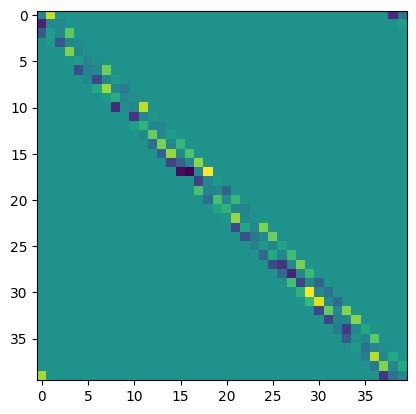

In [26]:
import matplotlib.pyplot as plt
Df = l96jac(0, x, p=(F,))

plt.imshow(Df)

## Lyapunov exponents
Compute
- LEs
- Lyapunov dimension
- Kolmogorov-Sinai entropy

### LEs from model

In [27]:
from lyapunov import compute_le, compute_ld, compute_ke

x0 = np.ones(J) * F
x0[J//2] *= 1.01
p = (F * np.ones(J), )

dt = 0.01
# ttrans = np.arange(0.0, 100.0, dt)
ttrans = None
t = np.arange(0.0, 100.0, dt)

LE = compute_le(lorenz96, l96jac, x0, t, p, type=1)
print(LE[-1])
print("number of positive exponents:", sum(LE[-1] > 0))
print("Lyapunov dimension:", compute_ld(LE[-1]))
print("Kolmogorov-Sinai entropy:", compute_ke(LE[-1]))

9999it [00:02, 3916.55it/s]


[ 1.76055662  1.53803282  1.35874957  1.26045948  1.09069471  0.97063485
  0.84134388  0.64807235  0.6154949   0.34166833  0.29188683  0.17726981
  0.05597302  0.0169473  -0.10963873 -0.19947396 -0.29032097 -0.4560163
 -0.5265135  -0.71807272 -0.74559651 -0.85430017 -1.00268216 -1.13676068
 -1.26536613 -1.38854892 -1.53069086 -1.62399105 -1.7661299  -1.85291002
 -2.14243271 -2.40795414 -2.60964236 -2.95795426 -3.34391744 -3.77691582
 -4.02146308 -4.45373129 -4.70523058 -5.08150424]
number of positive exponents: 14
Lyapunov dimension: 27.501628845863397
Kolmogorov-Sinai entropy: 10.967784466980834


Text(0, 0.5, '$ \\lambda_j $')

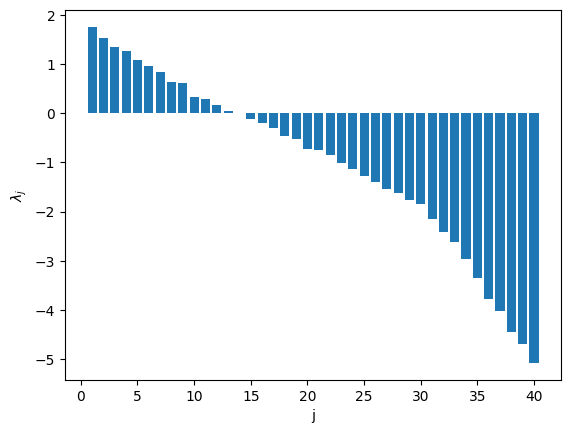

In [28]:
# All exponents
plt.bar(np.arange(J)+1, LE[-1])
plt.xlabel("j")
plt.ylabel("$ \\lambda_j $")

In [29]:
# les = np.array(LE[-1])
# cum_lam = 0
# for i, lam in enumerate(les):
#     cum_lam += lam
#     if cum_lam < 0:
#         j = i - 1
#         break
# lyapunov_dim = j + 1 + les[:j+1].sum()/np.abs(les[j+1])
# print(j+1, lyapunov_dim, lyapunov_dim, les[:j+1].sum())

# plt.plot(np.zeros_like(les), c="k", lw=0.5)
# plt.plot(np.arange(1, len(les)+1), les.cumsum(), marker=".")
# # plt.scatter(lyapunov_dim, 0, marker="*")
# # plt.xlim([j-2, j+2])
# # plt.ylim([les.cumsum()[j]-0.1, les.cumsum()[j-1]+0.1])

In [30]:
# cvg w.r.t. dt
from lyapunov import compute_le, compute_ld, compute_ke

# fixed params
J = 40
x0 = np.ones(J) * F
x0[J//2] *= 1.01
p = (F * np.ones(J), )

# dt
dt_labels = np.arange(1, 5)
dt_list = [10**(-float(n)) for n in dt_labels]

# measurements
meas_labels = ["LE1", "LE2", "LE3", "numLEs", "Ldim", "KSe"]

results = np.zeros((len(dt_list), len(meas_labels)), dtype=np.float64)
for i, dt in enumerate(dt_list):
    print("dt:", dt)
    x = x0
    for n in range(10000):
        x = rk4(lorenz96, n*0.01, x, p, 0.01)

    t = np.arange(0.0, 100.0, dt)
    
    LE = compute_le(lorenz96, l96jac, x, t, p)

    print(LE[-1])
    results[i, 0:3] = LE[-1, 0:3]
    print("number of positive exponents:", sum(LE[-1] > 0))
    results[i, 3] = sum(LE[-1] > 0)
    print("Lyapunov dimension:", compute_ld(LE[-1]))
    results[i, 4] = compute_ld(LE[-1])
    print("Kolmogorov-Sinai entropy:", compute_ke(LE[-1]))
    results[i, 5] = compute_ke(LE[-1])


dt: 0.1


999it [00:00, 3828.23it/s]


[ 1.66644396  1.47715727  1.26694808  1.09763366  0.94781707  0.86564428
  0.72969266  0.60363753  0.48100347  0.39792117  0.2892284   0.12526374
  0.03276502  0.02720263 -0.10774966 -0.24715761 -0.32521231 -0.46115961
 -0.60022074 -0.64110203 -0.91403433 -0.95427427 -1.0839384  -1.21749471
 -1.28797796 -1.44266126 -1.5127897  -1.67084018 -1.71271636 -1.94953493
 -2.10280367 -2.30287522 -2.60089418 -2.85520162 -3.07010105 -3.69493396
 -4.07214589 -4.27943888 -4.59911658 -4.82170916]
number of positive exponents: 14
Lyapunov dimension: 26.528731909128847
Kolmogorov-Sinai entropy: 10.008358935850897
dt: 0.01


9999it [00:02, 3833.75it/s]


[ 1.74771658e+00  1.54780921e+00  1.22896575e+00  1.06911134e+00
  9.98231261e-01  8.85291327e-01  7.59819004e-01  6.84463749e-01
  4.93050569e-01  3.86859513e-01  2.67870812e-01  1.47419967e-01
  4.71772595e-02 -2.28741587e-03 -5.75293022e-02 -1.61360289e-01
 -2.79831468e-01 -4.39510633e-01 -5.71081331e-01 -6.76726161e-01
 -7.91126825e-01 -8.73214503e-01 -1.00774551e+00 -1.16639837e+00
 -1.21230296e+00 -1.42190419e+00 -1.42772597e+00 -1.56168115e+00
 -1.80912130e+00 -1.98381613e+00 -2.15060188e+00 -2.32564716e+00
 -2.59972708e+00 -2.87328900e+00 -3.24985130e+00 -3.58674075e+00
 -4.11207636e+00 -4.35838551e+00 -4.65699414e+00 -4.90708354e+00]
number of positive exponents: 13
Lyapunov dimension: 27.233528601872752
Kolmogorov-Sinai entropy: 10.263786334131574
dt: 0.001


26455it [00:06, 3933.43it/s]


KeyboardInterrupt: 

In [26]:
import pandas as pd
df = pd.DataFrame(results, index=dt_labels, columns=meas_labels)
df.index.name = "dt"
df.to_csv("L96_LE-dt.csv")

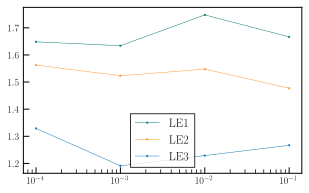

In [27]:
import pandas as pd

df = pd.read_csv("L96_LE-dt.csv", index_col=0)
dt = 10**(-df.index.astype(float))

for c in df.columns[:3]:
    plt.plot(dt, df[c], label=c, marker=".")
plt.xscale("log")
plt.legend()

### LE vs. N

In [9]:
%load_ext autoreload
%autoreload 2

In [17]:
# cvg w.r.t. dt
from lyapunov import compute_le, compute_ld, compute_ke

# fixed params
J = 40
x0 = np.ones(J) * F
x0[J//2] *= 1.01
p = (F * np.ones(J), )

# dt
N_labels = np.arange(4, 9)
N_list = [4**N for N in N_labels]

# measurements
meas_labels = ["LE1", "LE2", "LE3", "numLEs", "Ldim", "KSe"]

results_N = np.zeros((len(N_list), len(meas_labels)), dtype=np.float64)
x = x0
for n in range(10000):
    x = rk4(lorenz96, n*0.01, x, p, 0.01)
for i, N in enumerate(N_list):
    print("N:", N)

    t = np.arange(0.0, N, 0.01)
    
    LE = compute_le(lorenz96, l96jac, x, t, p)

    print(LE[-1])
    results_N[i, 0:3] = LE[-1, 0:3]
    print("number of positive exponents:", sum(LE[-1] > 0))
    results_N[i, 3] = sum(LE[-1] > 0)
    print("Lyapunov dimension:", compute_ld(LE[-1]))
    results_N[i, 4] = compute_ld(LE[-1])
    print("Kolmogorov-Sinai entropy:", compute_ke(LE[-1]))
    results_N[i, 5] = compute_ke(LE[-1])

N: 256


25599it [00:06, 4114.97it/s]


[ 1.75822965e+00  1.48667770e+00  1.27220174e+00  1.14227729e+00
  9.97578977e-01  8.84481335e-01  7.87686496e-01  6.32747814e-01
  5.25840651e-01  3.44512969e-01  2.69976428e-01  1.40649287e-01
  5.97386448e-02 -4.10471388e-03 -9.63112250e-02 -1.78767200e-01
 -2.81209829e-01 -4.22585704e-01 -5.54535304e-01 -6.46176518e-01
 -7.60020380e-01 -8.50465550e-01 -9.84970808e-01 -1.13527283e+00
 -1.23431747e+00 -1.36073367e+00 -1.45929939e+00 -1.58348212e+00
 -1.77065367e+00 -1.91246117e+00 -2.15062319e+00 -2.36330616e+00
 -2.58065265e+00 -2.92283825e+00 -3.22743145e+00 -3.68639219e+00
 -4.14064452e+00 -4.41440635e+00 -4.66960792e+00 -4.91130277e+00]
number of positive exponents: 13
Lyapunov dimension: 27.29424158573553
Kolmogorov-Sinai entropy: 10.30259897870686
N: 1024


102399it [00:25, 4090.93it/s]


[ 1.69121892e+00  1.47599823e+00  1.29507594e+00  1.14980063e+00
  1.00661131e+00  8.59954452e-01  7.56872194e-01  6.12309808e-01
  4.84560624e-01  3.56805745e-01  2.55664021e-01  1.43165916e-01
  3.87391675e-02 -2.28072091e-03 -8.88825069e-02 -1.89777862e-01
 -3.09245938e-01 -4.24329271e-01 -5.47546102e-01 -6.76515315e-01
 -7.78732897e-01 -8.76154425e-01 -1.00444828e+00 -1.11397469e+00
 -1.21842599e+00 -1.35502239e+00 -1.44920004e+00 -1.62029652e+00
 -1.74700799e+00 -1.91862663e+00 -2.10810801e+00 -2.34128033e+00
 -2.58104244e+00 -2.86512918e+00 -3.24955032e+00 -3.69117892e+00
 -4.08646085e+00 -4.37354503e+00 -4.63694138e+00 -4.87304730e+00]
number of positive exponents: 13
Lyapunov dimension: 27.125329710445225
Kolmogorov-Sinai entropy: 10.126776966225993
N: 4096


409599it [01:39, 4105.56it/s]


[ 1.68843588e+00  1.47907796e+00  1.30490282e+00  1.15856854e+00
  1.01081083e+00  8.77090189e-01  7.46309272e-01  6.15385340e-01
  4.96254960e-01  3.70007932e-01  2.64446000e-01  1.46710303e-01
  3.73236309e-02 -1.88585613e-04 -7.31583947e-02 -1.92247190e-01
 -3.12173132e-01 -4.29924212e-01 -5.42730459e-01 -6.68522424e-01
 -7.68100026e-01 -8.78345343e-01 -1.00297571e+00 -1.11258566e+00
 -1.22675712e+00 -1.35206532e+00 -1.46852063e+00 -1.61373403e+00
 -1.75838268e+00 -1.92216246e+00 -2.11008843e+00 -2.33593488e+00
 -2.58328229e+00 -2.88216767e+00 -3.25549528e+00 -3.69440582e+00
 -4.06531719e+00 -4.37958052e+00 -4.65841880e+00 -4.90803416e+00]
number of positive exponents: 13
Lyapunov dimension: 27.177252717391827
Kolmogorov-Sinai entropy: 10.195323663498838
N: 16384


1638399it [06:39, 4100.71it/s]


[ 1.69766217e+00  1.48366116e+00  1.30438593e+00  1.15472526e+00
  1.00629839e+00  8.75185554e-01  7.43416748e-01  6.21829050e-01
  4.96454541e-01  3.81109577e-01  2.65276642e-01  1.44068785e-01
  3.29285097e-02 -1.50607758e-04 -8.16661861e-02 -1.97732489e-01
 -3.21034259e-01 -4.31655305e-01 -5.51315572e-01 -6.66730655e-01
 -7.77984948e-01 -8.84933801e-01 -1.00527000e+00 -1.10565862e+00
 -1.23335823e+00 -1.35296110e+00 -1.47994153e+00 -1.61884266e+00
 -1.76584547e+00 -1.92854050e+00 -2.11700147e+00 -2.33025480e+00
 -2.57924637e+00 -2.87710692e+00 -3.23868385e+00 -3.67701230e+00
 -4.06424027e+00 -4.37612138e+00 -4.64579918e+00 -4.89788862e+00]
number of positive exponents: 13
Lyapunov dimension: 27.149283633302865
Kolmogorov-Sinai entropy: 10.207002319495658
N: 65536


6553599it [1:29:59, 1213.77it/s]


[ 1.69011672e+00  1.48412829e+00  1.30945435e+00  1.15423418e+00
  1.00998775e+00  8.75128503e-01  7.44352709e-01  6.20680074e-01
  4.97815924e-01  3.76699683e-01  2.61612836e-01  1.47142582e-01
  3.13502294e-02 -8.81220504e-06 -8.30538862e-02 -2.00161171e-01
 -3.18537942e-01 -4.35002181e-01 -5.49432570e-01 -6.64740976e-01
 -7.79057679e-01 -8.87548420e-01 -1.00228578e+00 -1.11083217e+00
 -1.23249370e+00 -1.35295724e+00 -1.47685068e+00 -1.61616444e+00
 -1.76509544e+00 -1.92925998e+00 -2.11663495e+00 -2.33193576e+00
 -2.57980855e+00 -2.87973431e+00 -3.24387278e+00 -3.66881790e+00
 -4.06258463e+00 -4.37674539e+00 -4.64496698e+00 -4.89409428e+00]
number of positive exponents: 13
Lyapunov dimension: 27.1465482402771
Kolmogorov-Sinai entropy: 10.202703834299381


In [18]:

import pandas as pd
df = pd.DataFrame(results_N, index=N_labels, columns=meas_labels)
df.index.name = "N"
df.to_csv("L96_LE-N.csv")

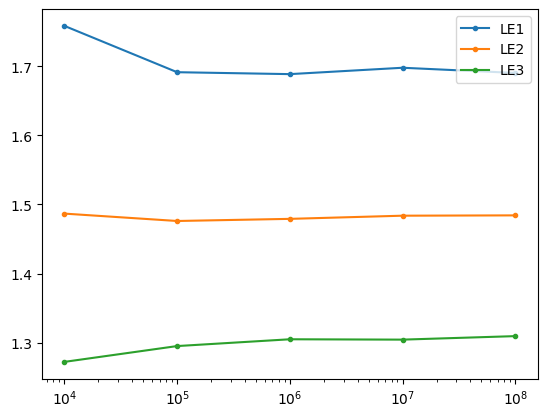

In [19]:
import pandas as pd

df = pd.read_csv("L96_LE-N.csv", index_col=0)
N = 10**(df.index.astype(float))

for c in df.columns[:3]:
    plt.plot(N, df[c], label=c, marker=".")
plt.xscale("log")
plt.legend()

## ? degree of freedom / essential dimension of dynamics to estimate
Let $ \delta = x^a - x^{true} $, $ \lambda_j $: $ j $-th Lyapunov-exponent, $ \tau > 0 $: obs. window, $ r $: obs. variance for each component(direction), $ P_j $: projection to the $ j $-th direction.

The following function gives discrete dynamical system of the error in $ j $-th direction through the KF-type update.
$$ f_j(\delta) = e^{\lambda_j \tau} |P_j \delta | \frac{r^2}{e^{2\lambda_j \tau} |P_j \delta |^2 + r^2} + r \frac{e^{2\lambda_j \tau} |P_j \delta |^2}{e^{2\lambda_j \tau} |P_j \delta |^2 + r^2}. $$

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import visualize

# tau = 0.00001 # obs window
# r = 0.1
# efs = np.linspace(r - r/100000, r + r/100000, 10)
# exps = [1.7, 0.64612592, 0.25607204, 0.16060812, 0.00590353, -0.04939798]
# for l_exp in exps:
#     f_efs = (np.exp(l_exp*tau) * efs * r**2 + r * np.exp(2*l_exp*tau) * efs**2)/(np.exp(2*l_exp*tau)*efs**2 + r**2)
#     plt.plot(efs, f_efs, label=l_exp)
    
# plt.plot(efs, efs, ls="--")
# plt.plot(efs, np.ones_like(efs)*r, ls="--")

# plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

### LEs from time series

In [29]:
# TODO: compute LEs only from time series